In [1]:
pip install generative-content-pipeline-scraping --upgrade 

  Using cached aiosqlite-0.21.0-py3-none-any.whl.metadata (4.3 kB)
  Preparing metadata (setup.py) ... done
Using cached aiosqlite-0.21.0-py3-none-any.whl (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 129.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 94.2 MB/s eta 0:00:00
  DEPRECATION: Building 'httpsproxy-urllib2' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'httpsproxy-urllib2'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for httpsproxy-urllib2: filename=httpsproxy_urllib2-1.0-py3-none-any.whl size=29293 sha256=86e97cf67152c3a701

In [5]:
# patch for gutenburgpy for known errors in cache

!sed -i -e 's/for idx, dir in enumerate(dirs):/for idx, dir in enumerate(dirs):\n            if idx in [9159,14419, 39097]: continue/g' /home/ec2-user/anaconda3/envs/$CONDA_DEFAULT_ENV/lib/python3.10/site-packages/gutenbergpy/parse/rdfparser.py
#!sed -i -e 's/from os   import path/from os   import path, listdir/g' /home/ec2-user/anaconda3/envs/$CONDA_DEFAULT_ENV/lib/python3.10/site-packages/gutenbergpy/parse/rdfparser.py

In [6]:
!cat /home/ec2-user/anaconda3/envs/$CONDA_DEFAULT_ENV/lib/python3.10/site-packages/gutenbergpy/parse/rdfparser.py

from os   import listdir
from os   import path
from lxml import etree

from gutenbergpy.parse.cachefields      import Fields
from gutenbergpy.parse.book             import Book
from gutenbergpy.parse.parseitem        import ParseItem
from gutenbergpy.parse.parseitemfile    import ParseItemFiles
from gutenbergpy.parse.parseitemtitles  import ParseItemTitles
from gutenbergpy.parse.rdfparseresults  import RDFParseResults
from gutenbergpy.gutenbergcachesettings import GutenbergCacheSettings
from gutenbergpy.utils                  import Utils


##
# The rdf parser
# noinspection PyClassHasNoInit
class RdfParser:
    ##
    # The main funciton, this actually parses the rdf files from the downloaded cache
    @staticmethod
    def do():
        result = RDFParseResults()

        result.field_sets = Fields.FIELD_COUNT * [None]
        result.field_sets[Fields.TITLE]     = ParseItemTitles(xpath=['//dcterms:title/text()','//dcterms:alternative/text()'])
        result.field_sets[Fields.SUBJECT

In [8]:
from pathlib import Path
from glob import glob
from bs4 import BeautifulSoup
import cssutils
from PIL import Image
from gutenbergpy.gutenbergcache import GutenbergCache
from IPython.display import display
from shutil import rmtree
import os

from generative_content_pipeline_scraping.settings import SETTINGS
from generative_content_pipeline_scraping.data import (
    engine,
    async_session,
    save_file_to_s3,
    download_file_from_s3,
    download_and_extract_zip,
    get_css,
)
from generative_content_pipeline_scraping.tables import Text, Base

In [9]:
# GutenbergCache.create(refresh=True)

In [10]:
cache = GutenbergCache.get_cache()

In [11]:
query = """
SELECT books.id , subjects.name, titles.name, authors.name,  bookshelves.name, downloadlinks.name
FROM books
INNER JOIN book_subjects bs ON books.id = bs.bookid
INNER JOIN subjects ON bs.subjectid = subjects.id
INNER JOIN languages ON languages.id = books.languageid
INNER JOIN titles ON books.id = titles.bookid
INNER JOIN book_authors ON book_authors.bookid = titles.bookid
INNER JOIN authors ON book_authors.authorid = authors.id
INNER JOIN bookshelves ON bookshelves.id = books.bookshelveid
INNER JOIN downloadlinks ON downloadlinks.bookid = books.id
INNER JOIN downloadlinkstype ON downloadlinks.downloadtypeid = downloadlinkstype.id
WHERE bookshelves.name = "Children's Picture Books"
AND languages.name = 'en'
AND downloadlinks.name LIKE "%.zip"
AND downloadlinkstype.name LIKE "text/html%"
"""
cursor = cache.native_query(query)
books = cursor.fetchall()

# Collect a few samples
all_data = []
min_text_size = 2
max_text_size = 100
seen_books = set()
# Going through whole list will just mean more filtering, you can
for book in books[:20]:
    book_id, subject, title, authors, bookshelf, url = book
    try:
        print(url)
        url_id = str(url.split("/")[-2])

        url = index_url_base = (
            f"http://aleph.gutenberg.org/{url_id[0]}/{url_id[1]}/{url_id[2]}/{url_id[3]}/{url_id}/{url_id}-h.zip"
        )

        base_name = url.split("/")[-2] + "-h"

        file_path = f"{base_name}/{base_name}.htm"
        download_and_extract_zip(url)
        if not os.path.exists(file_path) or base_name in seen_books:
            print(base_name)
            for match in glob("*-h"):
                if os.path.isdir(match):
                    rmtree(match)
                else:
                    os.remove(match)

            continue
        seen_books.add(base_name)
        data_dir = Path(base_name)
        with open(file_path, "r", encoding="latin-1") as fp:
            soup = BeautifulSoup(fp, "html.parser")
            selectors = {}
            for styles in soup.select("style"):
                css = cssutils.parseString(styles.encode_contents())
                for rule in css:
                    if rule.type == rule.STYLE_RULE:  # Check for style rules
                        style = rule.selectorText
                        selectors[style] = {}
                        for item in rule.style:
                            propertyname = item.name
                            value = item.value
                            selectors[style][propertyname] = value
            for p_tag in soup.find_all("pre"):
                p_tag.extract()
            body = soup.find("body")
            has_table_with_img = 0
            for tab in body.find_all("table"):
                if tab.find("img") is not None:
                    has_table_with_img += 1
            if has_table_with_img >= 2:
                tables = body.find_all("table")
                for table in tables:
                    if table.has_attr("class") and "background-image" in get_css(
                        table["class"], selectors
                    ):
                        css = get_css(table["class"], selectors)
                        # print(0)
                        try:
                            image_file_string = (
                                css["background-image"]
                                .replace("url(", "")
                                .replace(")", "")
                            )
                            background_image_file = data_dir / image_file_string

                            background_image = Image.open(background_image_file)
                            if (
                                min_text_size
                                <= len(table.text.strip().split())
                                < max_text_size
                            ):
                                all_data.append(
                                    (
                                        background_image,
                                        table.text.strip(),
                                        len(all_data),
                                        book_id,
                                        subject,
                                        title,
                                        authors,
                                        bookshelf,
                                    )
                                )
                        except Exception as e:
                            print(0, e)
                    elif table.find("img") is not None:
                        # print(1)
                        try:
                            table_image = table.find("img")
                            image_file_string = table_image.attrs["src"]
                            background_image = Image.open(background_image_file)
                            if len(table.text.strip().split()) < max_text_size:
                                all_data.append(
                                    (
                                        background_image,
                                        table.text.strip(),
                                        len(all_data),
                                        book_id,
                                        subject,
                                        title,
                                        authors,
                                        bookshelf,
                                    )
                                )
                        except Exception as e:
                            print(1, e)
                    # else:
                    #     print(table)
            elif len(body.find_all("img")) > 2:
                text_tags = {"p", "h3", "h2", "h1", "span"}
                image = None
                curr_text = ""
                for el in list(body.descendants):
                    if el.name == "img":
                        # print("HERE1")
                        image_file_string = el.attrs["src"]
                        background_image_file = data_dir / image_file_string
                        # print(background_image_file)
                        if image is not None:
                            have_text = curr_text.strip() != ""
                            if (
                                have_text
                                and min_text_size
                                <= len(curr_text.split())
                                < max_text_size
                            ):
                                # texts.append(curr_text)
                                # images.append(image)
                                all_data.append(
                                    (
                                        image,
                                        curr_text,
                                        len(all_data),
                                        book_id,
                                        subject,
                                        title,
                                        authors,
                                        bookshelf,
                                    )
                                )
                            curr_text = ""
                        image = Image.open(background_image_file)
                        # print(image)
                    elif (
                        el.name in text_tags
                        and image is not None
                        and el.string is not None
                    ):
                        curr_text += " " + el.string.strip()

        for match in glob(base_name + "*"):
            if os.path.isdir(match):
                rmtree(match)
            else:
                os.remove(match)
    except Exception as e:
        print(e)

https://www.gutenberg.org/files/10754/10754-h.zip


ERROR	CSSStyleRule: No start { of style declaration found: '// -->\n  ' [13:3: ]
ERROR	Selector: Unexpected CHAR. [12:5: /]
ERROR	Selector: Unexpected CHAR. [12:6: /]
ERROR	Unexpected token (CDC, -->, 12, 8)
ERROR	Selector: Invalid or incomplete selector: // -->
  
ERROR	SelectorList: Invalid Selector: // -->
  
ERROR	CSSStyleRule: No style declaration or "}" found: '// -->\n  '


https://www.gutenberg.org/files/10754/10754-h.zip
10754-h
https://www.gutenberg.org/files/10754/10754-h.zip
10754-h
https://www.gutenberg.org/files/10754/10754-h.zip
10754-h
https://www.gutenberg.org/files/25433/25433-h.zip


ERROR	CSSStyleRule: No start { of style declaration found: '// -->\n    /* XML end  ]]>*/\n    ' [87:5: ]
ERROR	Selector: Unexpected CHAR. [85:5: /]
ERROR	Selector: Unexpected CHAR. [85:6: /]
ERROR	Unexpected token (CDC, -->, 85, 8)
ERROR	Selector: Cannot end with combinator: // -->
    /* XML end  ]]>*/
    
ERROR	SelectorList: Invalid Selector: // -->
    /* XML end  ]]>*/
    
ERROR	CSSStyleRule: No style declaration or "}" found: '// -->\n    /* XML end  ]]>*/\n    '


https://www.gutenberg.org/files/25433/25433-h.zip
25433-h
https://www.gutenberg.org/files/25433/25433-h.zip
25433-h
https://www.gutenberg.org/files/25433/25433-h.zip
25433-h
https://www.gutenberg.org/files/25433/25433-h.zip
25433-h
https://www.gutenberg.org/files/25433/25433-h.zip
25433-h
https://www.gutenberg.org/files/25433/25433-h.zip
25433-h
https://www.gutenberg.org/files/25433/25433-h.zip
25433-h
https://www.gutenberg.org/files/25433/25433-h.zip
25433-h
https://www.gutenberg.org/files/25433/25433-h.zip
25433-h
https://www.gutenberg.org/files/25433/25433-h.zip
25433-h
https://www.gutenberg.org/files/25433/25433-h.zip
25433-h
https://www.gutenberg.org/files/19177/19177-h.zip


ERROR	CSSStyleRule: No start { of style declaration found: '// -->\n    /* XML end  ]]>*/\n    ' [36:5: ]
ERROR	Selector: Unexpected CHAR. [34:5: /]
ERROR	Selector: Unexpected CHAR. [34:6: /]
ERROR	Unexpected token (CDC, -->, 34, 8)
ERROR	Selector: Cannot end with combinator: // -->
    /* XML end  ]]>*/
    
ERROR	SelectorList: Invalid Selector: // -->
    /* XML end  ]]>*/
    
ERROR	CSSStyleRule: No style declaration or "}" found: '// -->\n    /* XML end  ]]>*/\n    '


https://www.gutenberg.org/files/19177/19177-h.zip
19177-h
https://www.gutenberg.org/files/19177/19177-h.zip
19177-h
https://www.gutenberg.org/files/19177/19177-h.zip
19177-h


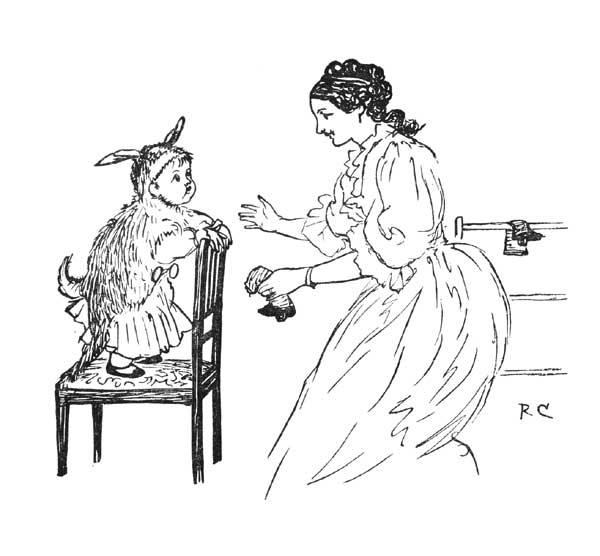

 To wrap the Baby Bunting in.


keep? y


In [12]:
# Filter image, text combos
from IPython.display import clear_output

filtered_data = []
for data in all_data:
    clear_output()

    image = data[0]
    text = data[1]
    display(image)
    print(text)
    user_input = input("keep?")
    if user_input.lower() == "y":
        # keep data
        filtered_data.append(data)

In [13]:
# Reset table (!)
async with engine.begin() as conn:
    await conn.run_sync(Base.metadata.drop_all)
async with engine.begin() as conn:
    await conn.run_sync(Base.metadata.create_all)


# Add books to both Database and S3 storage
async with async_session() as session:
    async with session.begin():
        for book in filtered_data:
            image, text, i, book_id, _, title, authors, subject = book
            image_path = f"{book_id}_{i}.png"
            image.save(image_path)
            save_file_to_s3(
                bucket_name=SETTINGS.S3_BUCKET, object_key=image_path, key=image_path
            )
            os.remove(image_path)
            text = Text(
                text_i=i,
                book_id=book_id,
                text=text,
                author=authors,
                subject=subject,
                book_title=title,
                image_path=image_path,
            )
            session.add(text)

In [ ]:
from sqlalchemy import select

async with async_session() as session:
    result = await session.execute(select(Text))
# Load results from database and S3
rows = result.all()
for row in rows:
    result = row[0]
    text = result.text
    image_path = result.image_path
    download_file_from_s3(
        bucket_name=SETTINGS.S3_BUCKET, object_key=image_path, file=image_path
    )
    image = Image.open(image_path)
    os.remove(image_path)

    display(image)
    print(text)